In [3]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import omicverse as ov
import pertpy as pt

In [4]:
def MergeSubAdata(adata, subAdata, obsName, subObsName):
    obs = pd.Series(list(adata.obs[obsName].copy()), index=adata.obs_names)
    subObs = pd.Series(list(subAdata.obs[subObsName].copy()), index=subAdata.obs_names)
    obs.loc[subObs.index] = subObs
    return pd.DataFrame(obs, columns=[obsName])

def marker(adata, groupby, method='wilcoxon', prefix=''):
    sc.tl.rank_genes_groups(adata, groupby = groupby, method = method)
    sc.tl.dendrogram(adata, groupby=groupby, use_rep='X_pca_harmony')
    sc.pl.rank_genes_groups_dotplot(adata, groupby = groupby, save=prefix+groupby+'.svg')
    return adata

def clu(adata, key_added="majorType-fix", n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=False, max_iter=20, do_scrublet=False, har_key='batch', resolution=1):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    if do_har and len(adata.obs[har_key].cat.categories) > 1:
        sc.external.pp.harmony_integrate(adata, key=har_key,max_iter_harmony=max_iter)
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    else:
        print("Evaluating neighbors only...")
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

In [ ]:
adata = sc.read_h5ad('/data/hanxue/hanxue_data/adata-xwt-annotated-Mye1.h5ad')

In [6]:
adata = adata[adata.obs['treat'].isin(['After']), :]

In [7]:
adata.obs['effect'] = 'better'
adata.obs.loc[adata.obs['batch'].isin(['13T', '19T']),'effect'] = 'better'
adata.obs.loc[adata.obs['batch'].isin(['11T', '12T', '16T']),'effect'] = 'worse'

... storing 'effect' as categorical


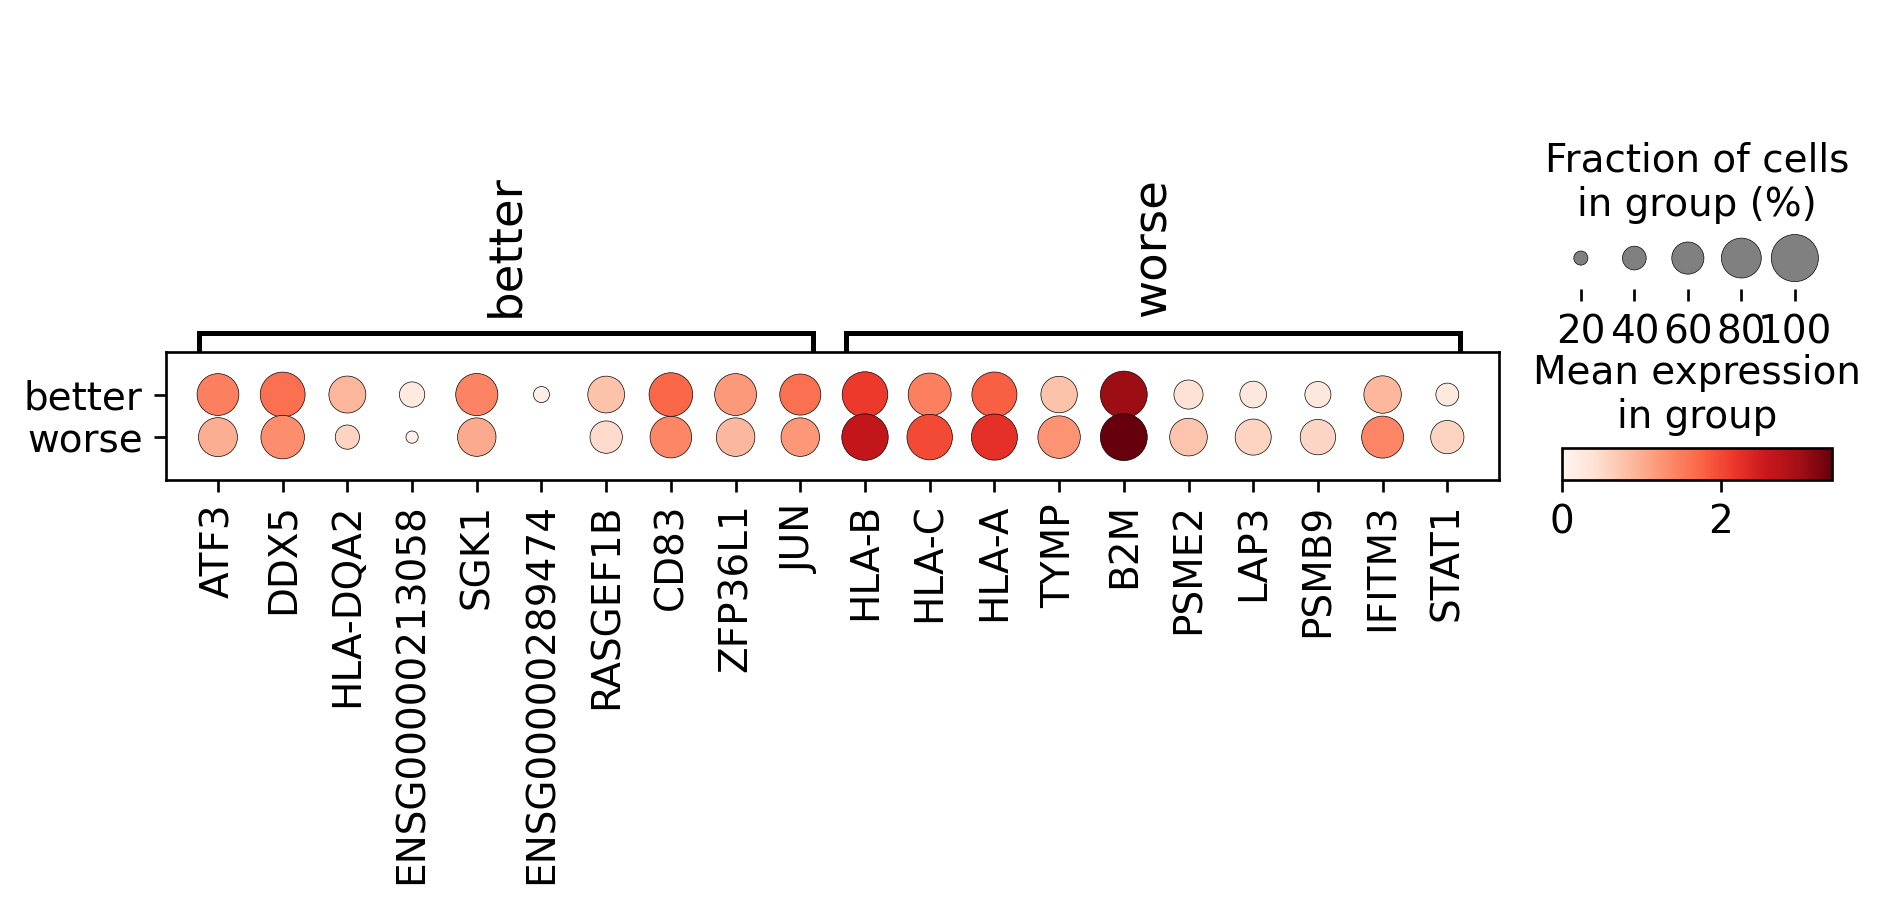

In [8]:
sc.tl.rank_genes_groups(adata, groupby = 'effect', method = 'wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata, groupby = 'effect', save='-Mye-effect.svg')

2025-09-09 03:42:41 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-09 03:42:41 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-09 03:42:41 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-09 03:42:41 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-09 03:42:41 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

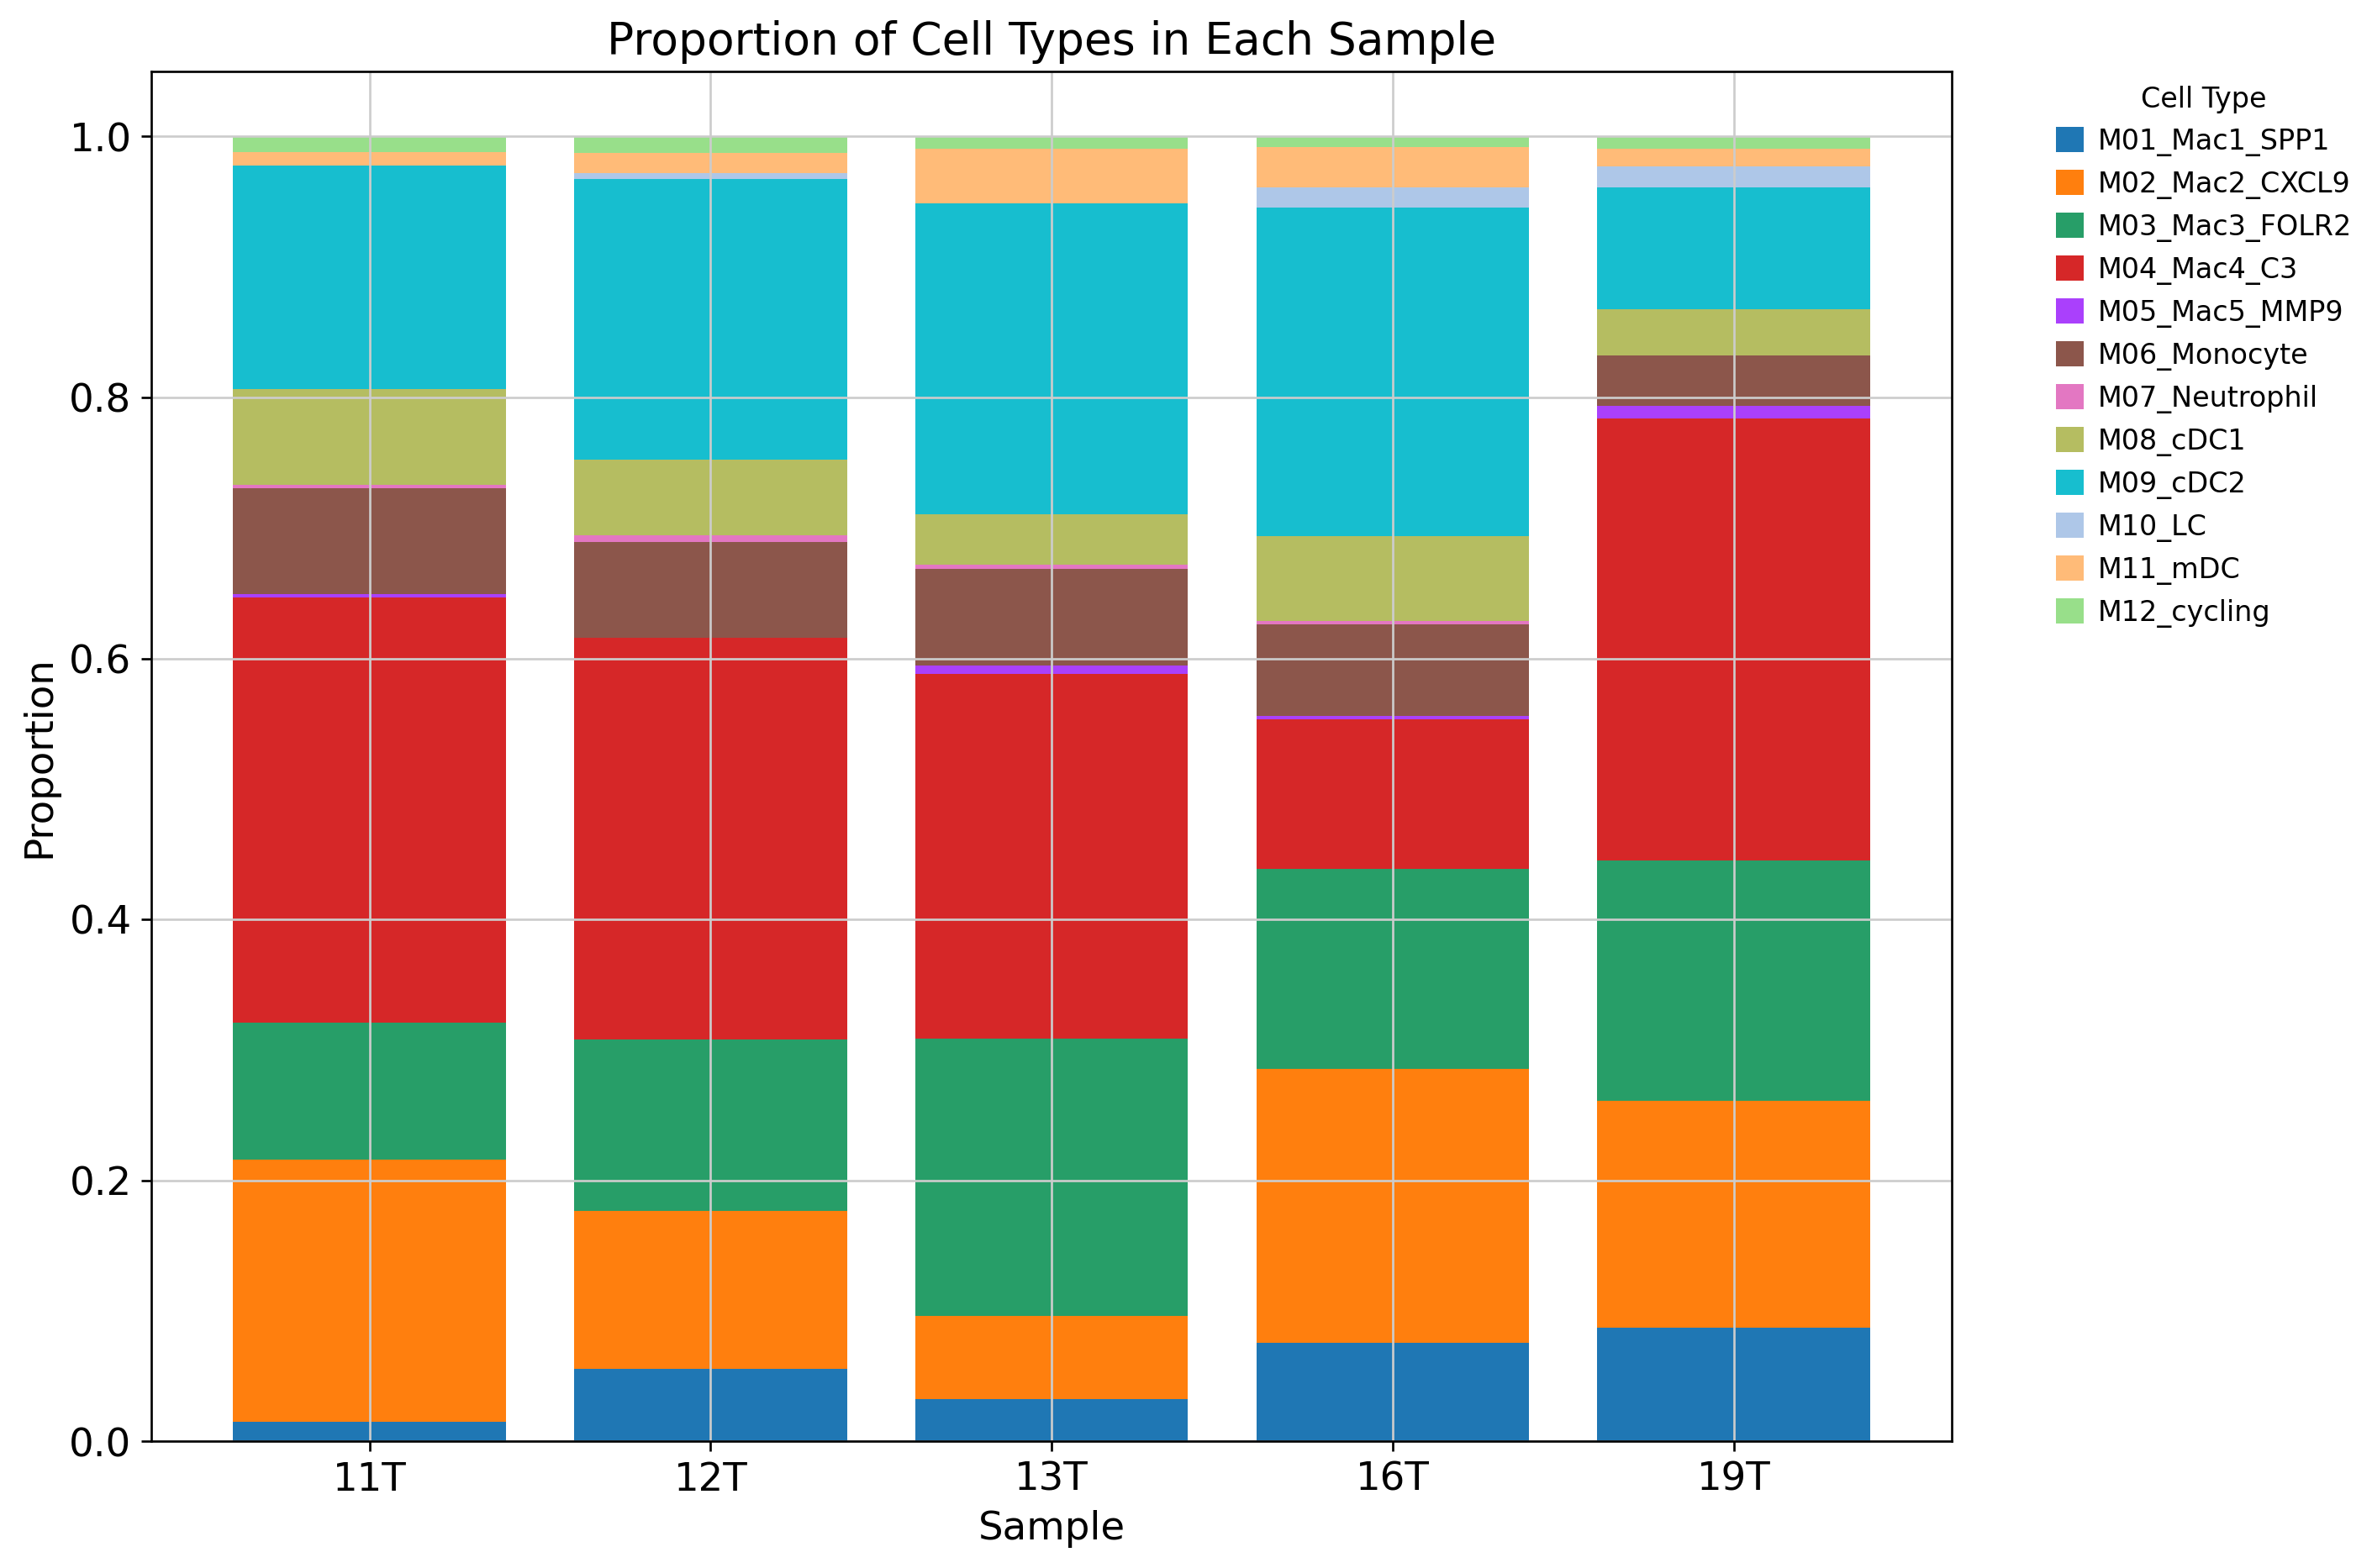

In [9]:
# 1. 计算每个样本中每种细胞类型的数量
cell_type_counts = adata.obs.groupby(['batch', 'anno-Mye1']).size().unstack(fill_value=0)

# 2. 计算每个样本的总细胞数
sample_totals = cell_type_counts.sum(axis=1)

# 3. 计算每种细胞类型在每个样本中的占比
proportions = cell_type_counts.div(sample_totals, axis=0)

# 4. 绘制堆叠条形图
fig, ax = plt.subplots(figsize=(12, 8))

# 遍历每个细胞类型，逐层堆叠
bottom = np.zeros(len(cell_type_counts.index))  # 初始化底部高度
for cell_type in proportions.columns:
    ax.bar(proportions.index, proportions[cell_type], bottom=bottom, label=cell_type)
    bottom += proportions[cell_type]  # 更新底部高度

# 添加标题和标签
ax.set_title('Proportion of Cell Types in Each Sample', fontsize=16)
ax.set_xlabel('Sample', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# 显示图形
plt.tight_layout()
plt.show()

#### 差异基因

In [10]:
# 选用高变基因
adata_highvar = adata[:, adata.var['highly_variable']].copy()

In [11]:
dds = ov.bulk.pyDEG(adata_highvar.to_df().T)
dds.drop_duplicates_index()

barcodes,AAACCTGCAATCCAAC-1-11T,AAACCTGGTACTCAAC-1-11T,AAACGGGCAGGATCGA-1-11T,AAAGCAAGTCTAGTCA-1-11T,AAAGCAAGTTCACCTC-1-11T,AAAGTAGCAAGCGAGT-1-11T,AAAGTAGGTCCAGTGC-1-11T,AAATGCCCACCGCTAG-1-11T,AACACGTGTAGGCTGA-1-11T,AACACGTGTCGTCTTC-1-11T,...,TTCTCAAGTTGGTTTG-1-19T,TTCTCCTCAAGACGTG-1-19T,TTCTCCTGTGTTAAGA-1-19T,TTGAACGCATGCAATC-1-19T,TTGCCGTCAGTAAGAT-1-19T,TTTCCTCAGGGTGTTG-1-19T,TTTCCTCTCAAACCGT-1-19T,TTTCCTCTCGGCTTGG-1-19T,TTTGCGCAGGTGTTAA-1-19T,TTTGTCAAGTCGTTTG-1-19T
name,,,,,,,,,,,,,,,,,,,,,
HSPA1B,2.349905,2.529582,0.978052,3.004694,2.916519,2.219122,1.753077,3.380335,2.687796,2.653843,...,2.680710,2.626014,1.319301,0.116162,3.285806,2.311662,3.589150,2.286791,2.447604,1.349998
FOS,1.781689,1.011505,3.492195,2.192940,0.598412,2.219122,2.549856,3.737532,0.000000,3.839368,...,3.617774,3.560559,0.942416,1.622327,0.000000,2.311662,3.673857,2.598691,3.819672,2.772678
SOD2,1.377236,2.472190,2.193272,2.666522,2.544924,1.149843,0.813539,0.946510,0.000000,0.000000,...,0.000000,0.000000,2.178253,0.553348,0.871644,2.056479,2.232246,1.490443,1.208005,0.000000
CCL3,0.000000,2.277132,1.605881,2.849835,2.057566,0.000000,1.389815,0.000000,0.000000,1.369969,...,1.343488,0.000000,1.208740,0.000000,0.000000,1.185645,4.329246,1.140695,0.776293,1.145197
GPR183,1.021860,1.713675,0.690926,0.895087,1.453231,1.149843,0.813539,0.000000,0.000000,1.369969,...,1.896836,0.000000,0.330413,0.116162,0.871644,0.000000,1.269828,0.684403,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CSN1S1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IL2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000286700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
better_groups = adata_highvar.obs[adata_highvar.obs['effect']=='better'].index.tolist() # 实验组
worse_groups = adata_highvar.obs[adata_highvar.obs['effect']=='worse'].index.tolist() # 对照组
deg_result = dds.deg_analysis(better_groups, worse_groups, method='ttest')

In [13]:
# 将平均表达量低于1的基因全部过滤掉
print(deg_result.shape)
deg_result=deg_result.loc[deg_result['log2(BaseMean)']>0]
print(deg_result.shape)

(1604, 12)
(6, 12)


In [14]:
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

... Fold change threshold: 1.7117011547088623


2025-09-09 03:42:43 | [WARNING] Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


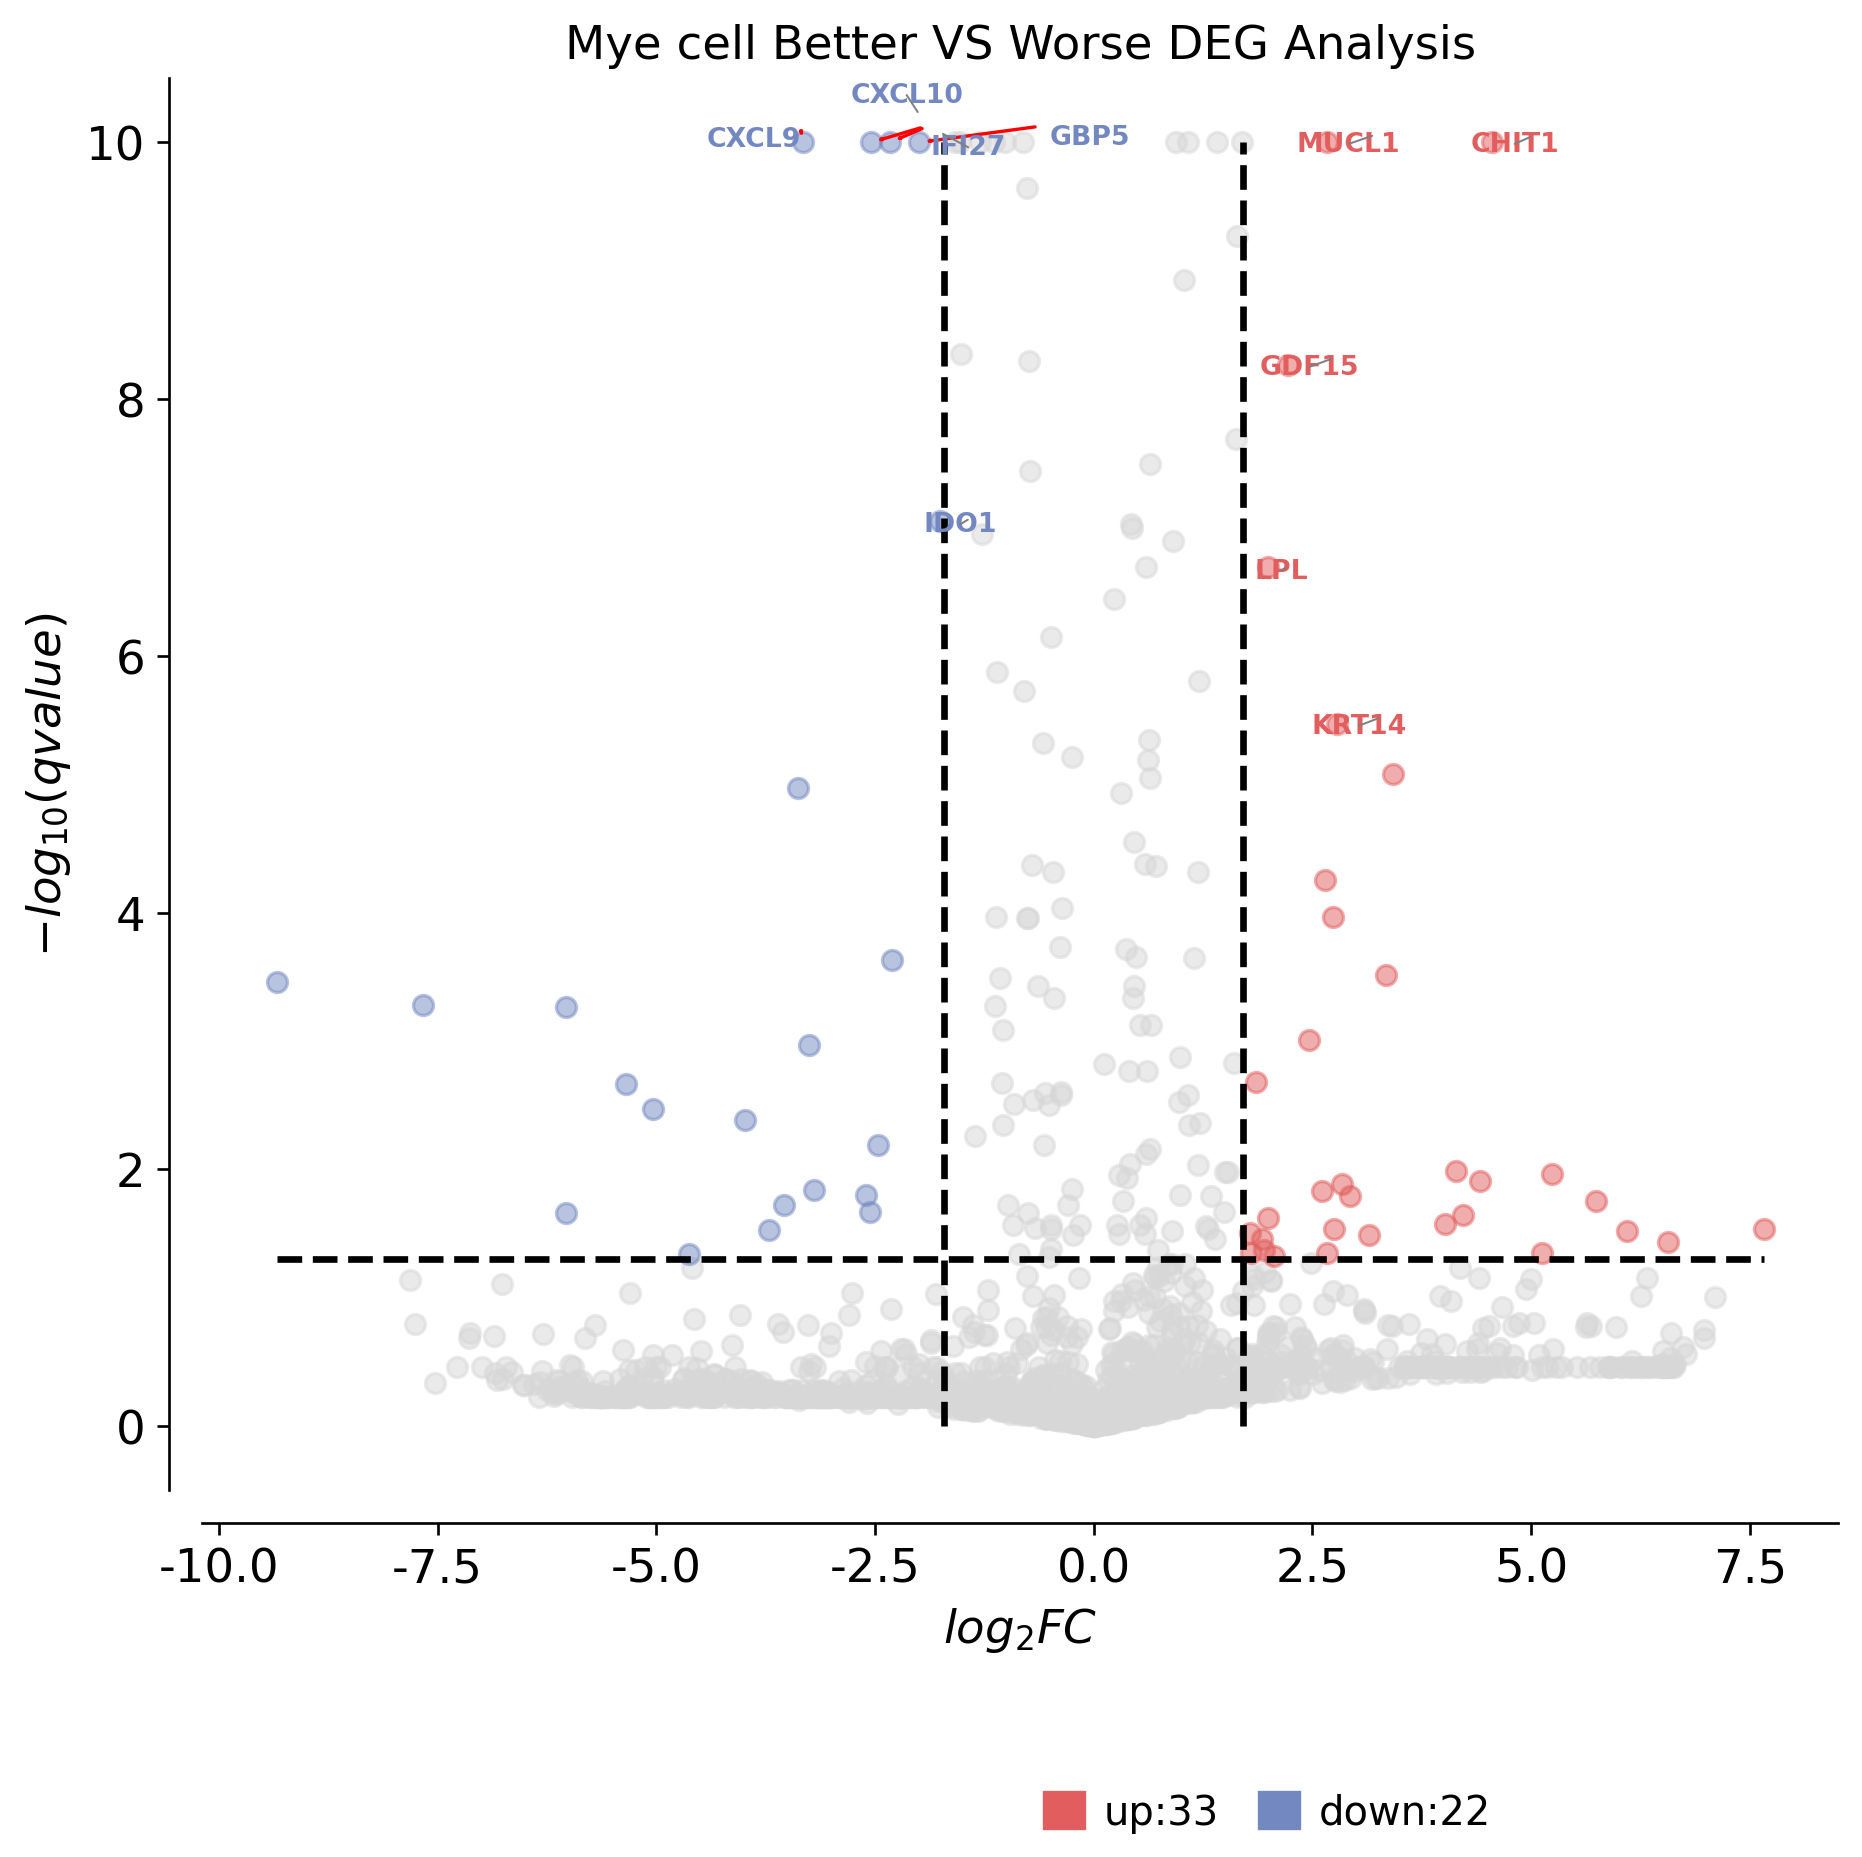

In [15]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# 画火山图
dds.plot_volcano(
    title='Mye cell Better VS Worse DEG Analysis',
    figsize=(8, 8),
    plot_genes_num=10,
    plot_genes_fontsize=8,
)

# 获取当前图像和坐标轴
fig = plt.gcf()
ax = plt.gca()

# 获取所有文本对象（即基因名标签）
texts = [txt for txt in ax.texts]

# 调整文本位置，同时延长点和基因名之间的连线
adjust_text(
    texts,
    ax=ax,
    force_text=0.5,   # 增加文本之间的排斥力（默认是 0.1~0.5）
    force_points=1.5, # 增加点和文本之间的排斥力（数值越大，距离越远）
    expand_text=(1.1, 1.5),  # 扩展文本移动范围
    arrowprops=dict(
        arrowstyle='-', color='gray', lw=0.6,
        shrinkA=0, shrinkB=5  # 控制箭头起止点缩进距离，增大 shrinkB 可“拉长”箭头
    )
)

fig.tight_layout()
fig.savefig('figures/Mye-after-DEGs-Expression-Volcano.svg', format='svg')



In [16]:
ov.utils.download_pathway_database()
#读取通路基因集，我们读取Wiki通路数据库
pathway_dict=ov.utils.geneset_prepare('genesets/MSigDB_Hallmark_2020.txt',organism='Human')

......Pathway Geneset download start: GO_Biological_Process_2021
......Loading dataset from genesets/GO_Biological_Process_2021.txt
......Pathway Geneset download start: GO_Cellular_Component_2021
......Loading dataset from genesets/GO_Cellular_Component_2021.txt
......Pathway Geneset download start: GO_Molecular_Function_2021
......Loading dataset from genesets/GO_Molecular_Function_2021.txt
......Pathway Geneset download start: WikiPathway_2021_Human
......Loading dataset from genesets/WikiPathway_2021_Human.txt
......Pathway Geneset download start: WikiPathways_2019_Mouse
......Loading dataset from genesets/WikiPathways_2019_Mouse.txt
......Pathway Geneset download start: Reactome_2022
......Loading dataset from genesets/Reactome_2022.txt
......Pathway Geneset download finished!
......Other Genesets can be dowload in `https://maayanlab.cloud/Enrichr/#libraries`


In [17]:
#差异表达基因提取
deg_genes=dds.result.loc[dds.result['sig']!='normal'].index.tolist()
#通路富集分析
enr=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='human')

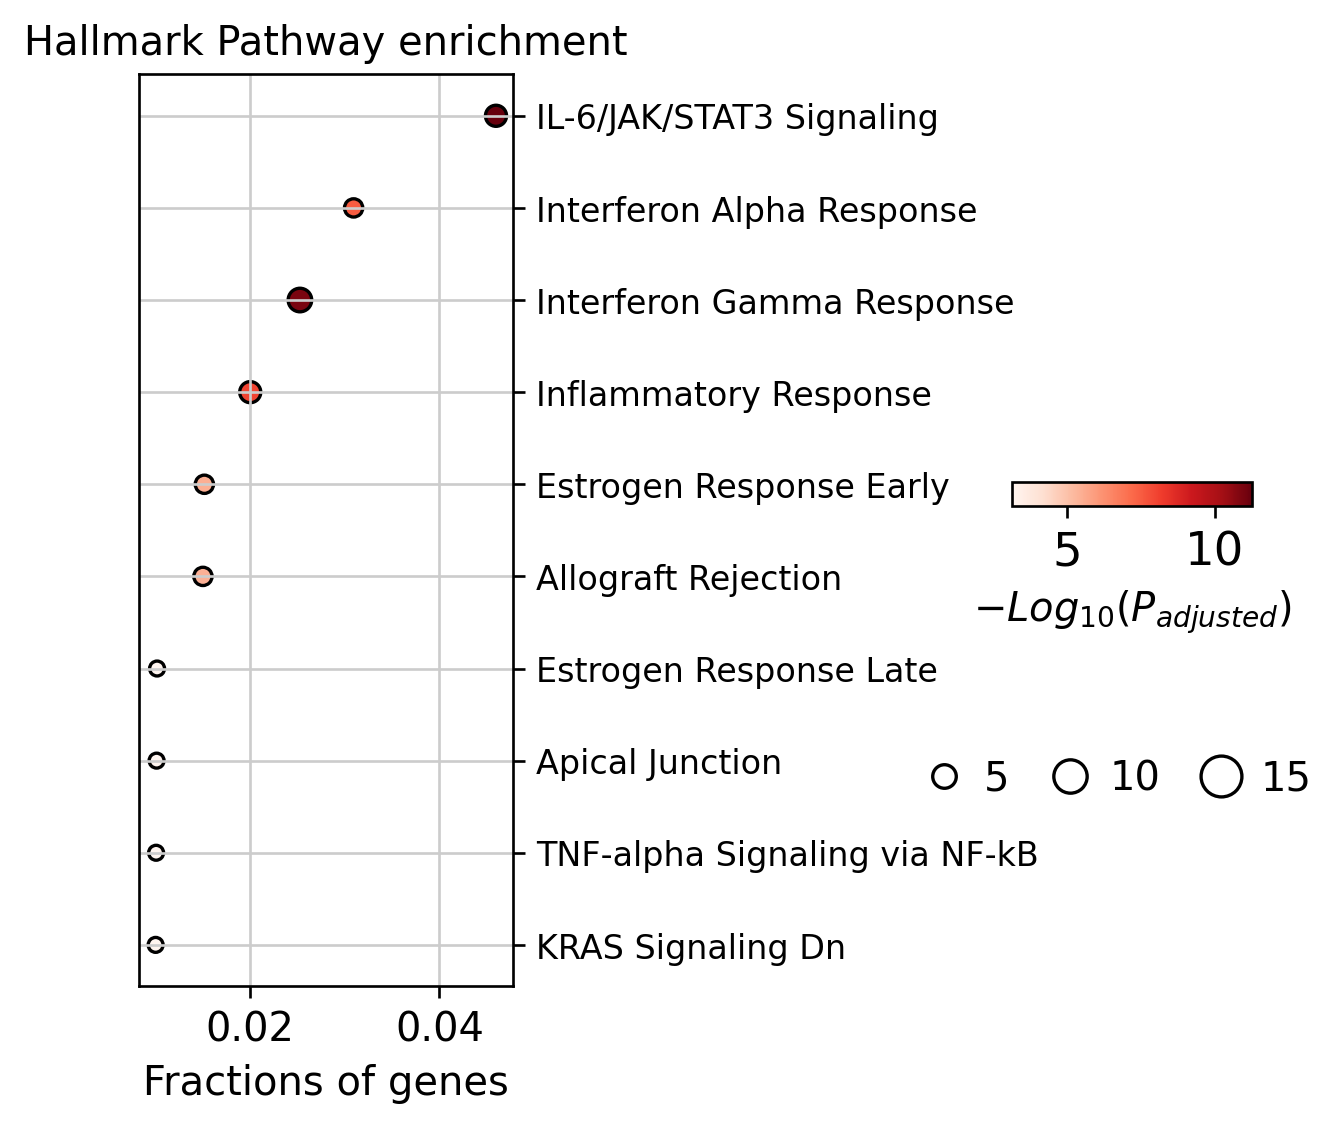

In [18]:
ov.bulk.geneset_plot(enr,figsize=(2,5),fig_title='Hallmark Pathway enrichment',
                        cmap='Reds')
#如果需要保存的话,使用`plt.savefig`来保存图像
plt.savefig("figures/Mye_after_pathway.svg",dpi=300,bbox_inches = 'tight')

#### 2T vs 其他

In [19]:
adata = sc.read_h5ad('/data/hanxue/hanxue_data/adata-xwt-annotated-Mye1.h5ad')

In [20]:
adata = adata[adata.obs['treat'].isin(['Before']), :]
adata = adata[adata.obs['batch'].isin(['2T', '9T']), :]

In [21]:
adata.obs['effect'] = 'better'
adata.obs.loc[adata.obs['batch'].isin(['9T']),'effect'] = 'better'
adata.obs.loc[adata.obs['batch'].isin(['2T']),'effect'] = 'worse'

In [22]:
# 选用高变基因
adata_highvar = adata[:, adata.var['highly_variable']].copy()

In [23]:
dds = ov.bulk.pyDEG(adata_highvar.to_df().T)
dds.drop_duplicates_index()

barcodes,AAACGAACAACCGCTG-1-2T,AAAGGATCATGACGTT-1-2T,AAAGGATGTATCGAAA-1-2T,AAAGGGCGTCGCACAC-1-2T,AAAGGGCGTTCGGTTA-1-2T,AAAGGTACATGTGCTA-1-2T,AAAGGTATCTTCCCGA-1-2T,AAAGTCCCAAGCGGAT-1-2T,AAATGGACAACAAGTA-1-2T,AACAACCTCTAGAGCT-1-2T,...,TTTGCGCAGGACGAAA-1-9T,TTTGCGCAGGAGTACC-1-9T,TTTGCGCCACACAGAG-1-9T,TTTGCGCCACACCGCA-1-9T,TTTGCGCCACGGCGTT-1-9T,TTTGCGCCACGTCTCT-1-9T,TTTGCGCTCTGAAAGA-1-9T,TTTGGTTAGAGCCCAA-1-9T,TTTGGTTTCCAAGTAC-1-9T,TTTGTCACATCCCACT-1-9T
name,,,,,,,,,,,,,,,,,,,,,
FOS,0.000000,0.000000,1.527550,1.073054,0.530229,0.000000,0.0,0.801029,0.000000,0.532258,...,2.935261,2.787204,2.755454,1.269982,0.586630,2.267166,3.024277,2.576187,2.786252,1.965467
SPP1,3.756436,2.895438,1.309725,4.634610,0.000000,2.661066,0.0,0.000000,0.000000,4.059142,...,0.242360,0.315977,0.463185,0.000000,3.671227,0.623369,0.000000,0.887500,3.653320,0.443417
FN1,1.008500,0.000000,1.179976,0.495569,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,2.777819,1.379469,2.192013,0.000000,3.720739,1.823130,1.764251,0.000000,2.287829,1.531940
TIMP1,4.053492,0.000000,0.372156,1.436788,0.000000,2.323924,0.0,1.044420,2.276817,0.532258,...,1.826290,2.556542,0.000000,0.000000,0.335729,1.279712,3.160127,1.665279,3.147725,1.965467
SOD2,1.008500,1.976171,1.030846,2.003414,0.530229,2.855517,0.0,0.000000,2.276817,1.778236,...,0.863423,0.315977,0.633233,0.000000,0.586630,0.000000,1.544469,0.000000,0.989959,0.983601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CASC19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000261670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000253477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
better_groups = adata_highvar.obs[adata_highvar.obs['effect']=='better'].index.tolist() # 实验组
worse_groups = adata_highvar.obs[adata_highvar.obs['effect']=='worse'].index.tolist() # 对照组
deg_result = dds.deg_analysis(better_groups, worse_groups, method='ttest')

In [25]:
# 将平均表达量低于1的基因全部过滤掉
print(deg_result.shape)
deg_result=deg_result.loc[deg_result['log2(BaseMean)']>0]
print(deg_result.shape)

(1694, 12)
(4, 12)


In [26]:
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

... Fold change threshold: 2.5916030406951904


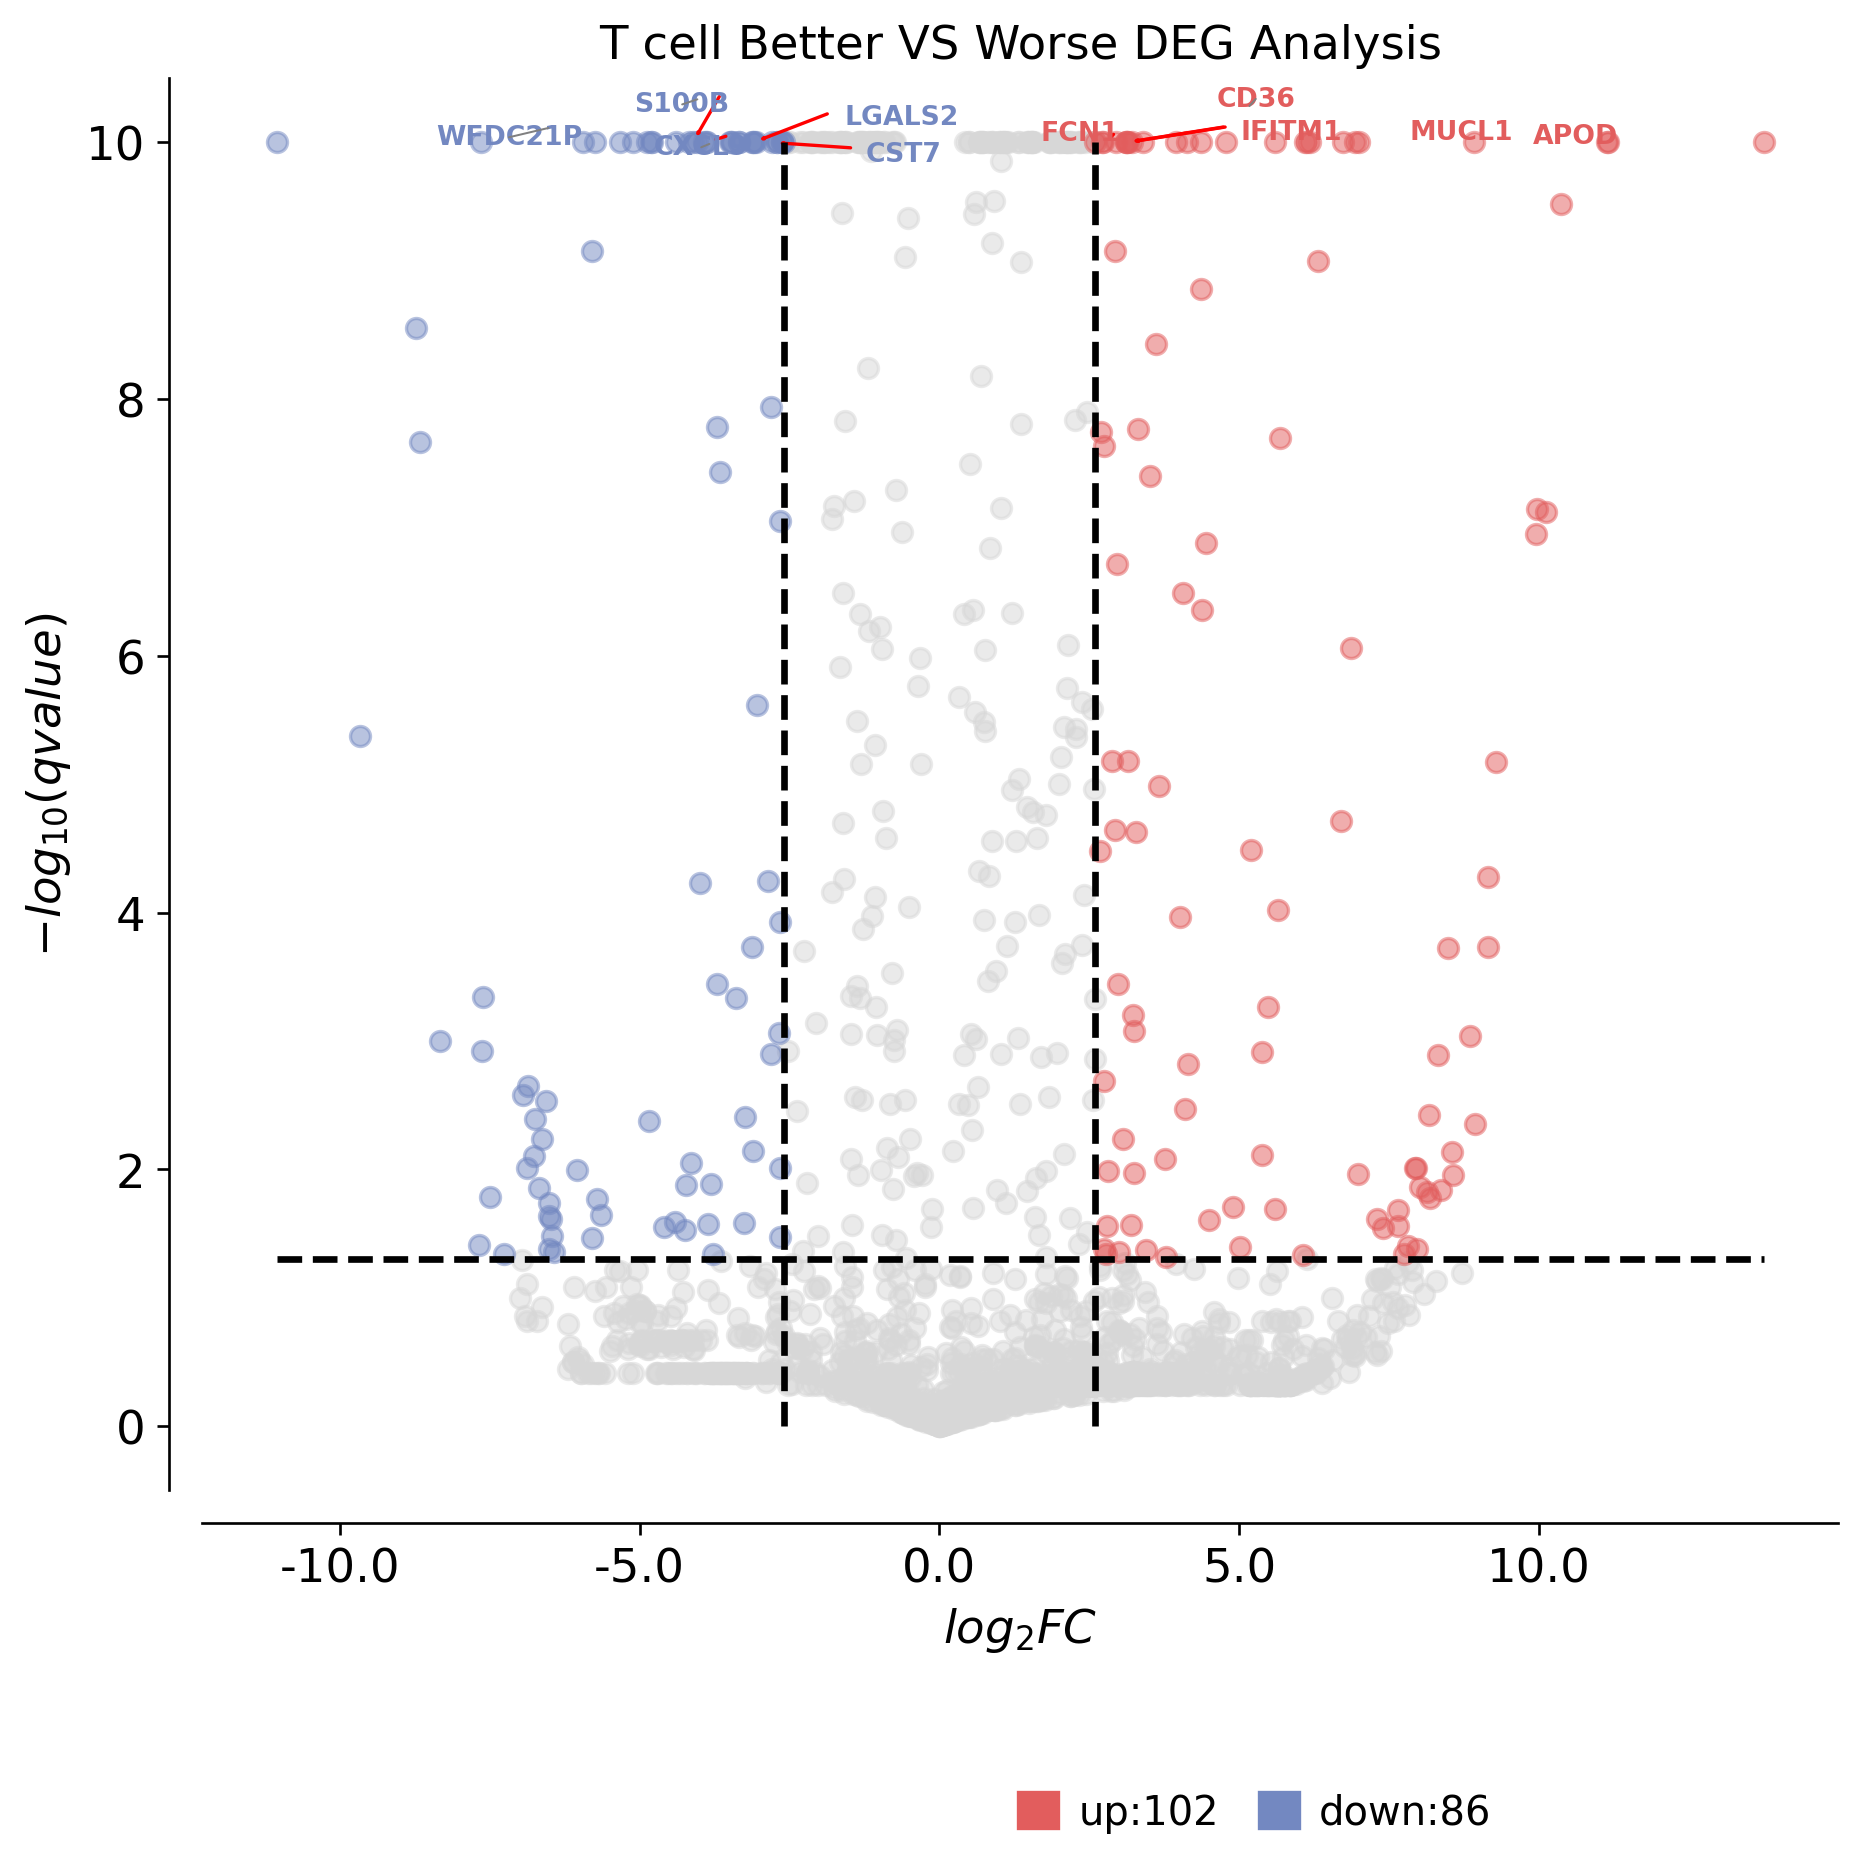

In [27]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

# 画火山图
dds.plot_volcano(
    title='T cell Better VS Worse DEG Analysis',
    figsize=(8, 8),
    plot_genes_num=10,
    plot_genes_fontsize=8,
)

# 获取当前图像和坐标轴
fig = plt.gcf()
ax = plt.gca()

# 获取所有文本对象（即基因名标签）
texts = [txt for txt in ax.texts]

# 调整文本位置，同时延长点和基因名之间的连线
adjust_text(
    texts,
    ax=ax,
    force_text=0.5,   # 增加文本之间的排斥力（默认是 0.1~0.5）
    force_points=1.5, # 增加点和文本之间的排斥力（数值越大，距离越远）
    expand_text=(1.1, 1.5),  # 扩展文本移动范围
    arrowprops=dict(
        arrowstyle='-', color='gray', lw=0.6,
        shrinkA=0, shrinkB=8  # 控制箭头起止点缩进距离，增大 shrinkB 可“拉长”箭头
    )
)

fig.tight_layout()
fig.savefig('figures/Mye-before-DEGs-Expression-Volcano.svg', format='svg')
